In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nibabel as nib
import copy

import torch
import torch.nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim

from layer import *
from unet import *

## 이미지 로딩

In [2]:
image_path = "C:/Users/user/Desktop/인턴/I001.nii.gz"
nifty = nib.load(image_path)
nifty_image = nifty.get_fdata()

In [5]:
nifty_image.shape[2]

32

In [3]:
slice = []
for i in range(nifty_image.shape[2]):
    slice.append(nifty_image[:, :, i])

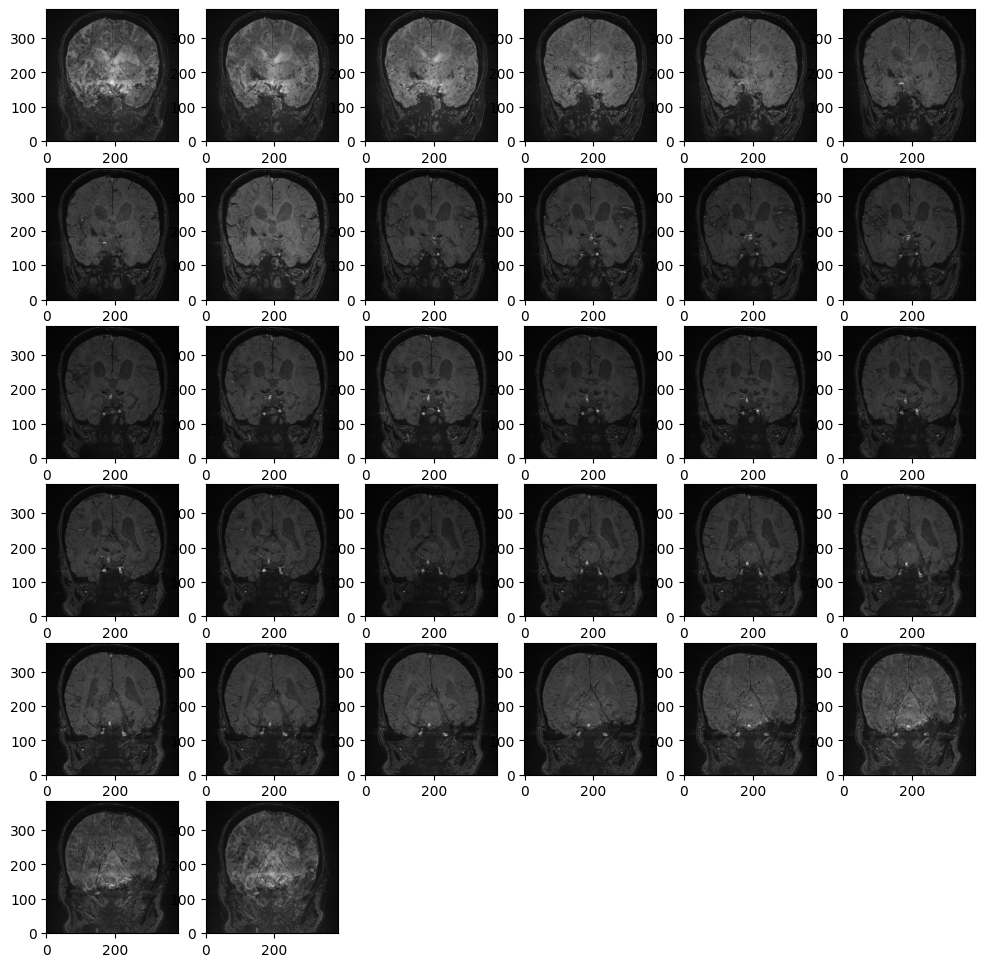

In [32]:
plt.figure(figsize=(12, 12))
for i in range(len(slice)):
    plt.subplot(6, 6, i + 1)
    plt.imshow(slice[i].T, cmap = "gray", origin = "lower")

## 랜덤한 N개 패치 생성

In [44]:
def generate_patch(image, patch_size):
    
    # 이미지 크기
    height, width = image.shape

    # 무작위한 패치의 시작점 결정
    top_left_x = np.random.randint(0, width - patch_size + 1)
    top_left_y = np.random.randint(0, height - patch_size + 1)

    # 이미지에서 무작위 패치 추출
    random_patch = image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size]

    return [random_patch, top_left_x, top_left_y]

In [48]:
patch = generate_patch(slice[0], 64)
random_patch, top_left_x, top_left_y = patch[0], patch[1], patch[2]

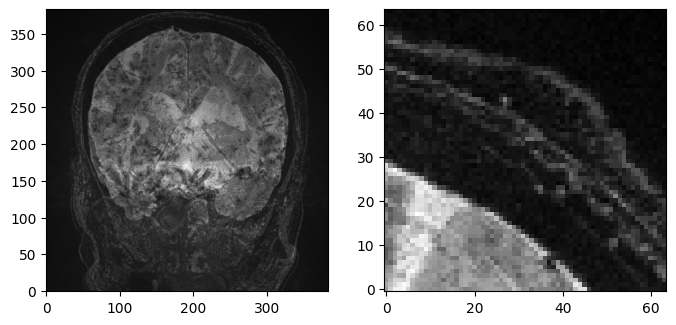

In [48]:
random_patch = generate_patch(slice[0], 64)

plt.figure(figsize= (8, 4))
plt.subplot(1, 2, 1)
plt.imshow(slice[0].T, cmap = "gray", origin = "lower")
plt.subplot(1, 2, 2)
plt.imshow(random_patch.T, cmap = "gray", origin = "lower")

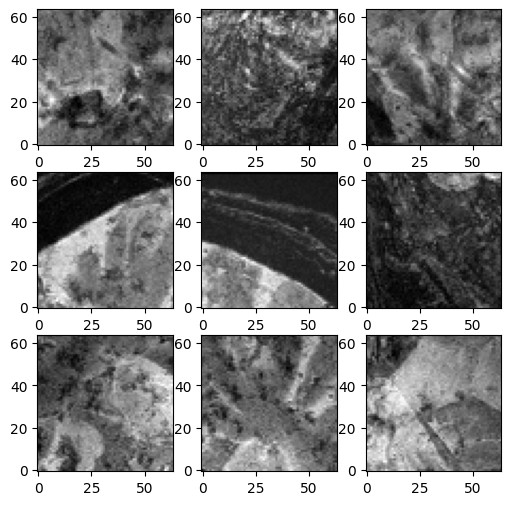

In [5]:
patch_list = []

plt.figure(figsize = (6, 6))
for i in range(9):
    patch = generate_patch(slice[0], 64)
    patch_list.append(patch)
    plt.subplot(3, 3, i + 1)
    plt.imshow(patch.T, cmap = "gray", origin = "lower")

In [18]:
patch_list[0].shape

(64, 64)

## 패치 내에서 랜덤하게 N개의 pixel 선택

## target: 랜덤하게 선택된 N개의 pixel masking & 대체하기

In [58]:
def generate_subpatch(patch_list, field_size, num_subpatches): # 패치 내에서 랜덤하게 receptive field 생성
    # 64x64 크기의 패치에서 5x5 크기의 receptive field 추출
    patch = patch_list[0]
    coordinate = []
    replace_value = []
    for i in range(num_subpatches):
        subpatch = generate_patch(patch, field_size)
        random_subpatch, top_row, top_col = subpatch[0], subpatch[1], subpatch[2]

        # center pixel 좌표
        center_row = top_row + (field_size // 2)
        center_col = top_col + (field_size // 2)
        pixel_value = patch[center_row, center_col]

        # receptive field 내의 랜덤한 pixel 추출
        replace_indices = np.random.choice(5 * 5, replace=False)

        subpatch_flat = random_subpatch.flatten()
        replace_value.append(subpatch_flat[replace_indices])
        coordinate.append([center_row, center_col, pixel_value])
    
    for i in range(len(coordinate)):
        row, col, replace = coordinate[i][0], coordinate[i][1], replace_value[i]
        patch[row, col] = replace
        
    return patch, coordinate

In [60]:
replaced_patch, coordinate = generate_subpatch(patch, 5, 100)

Text(0.5, 1.0, 'Input')

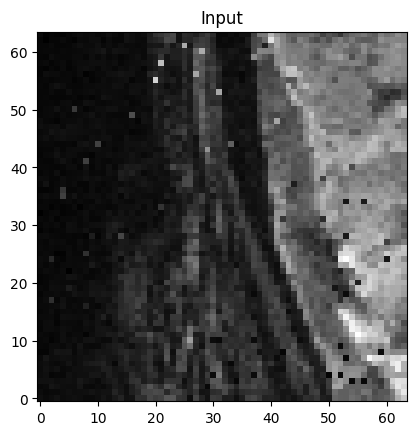

In [63]:
plt.imshow(replaced_patch.T, cmap = "gray", origin = "lower")
plt.title("Input")

In [64]:
maskmap = np.zeros((64, 64), dtype=np.int8)

for i in range(len(coordinate)):
        row, col, value = coordinate[i][0], coordinate[i][1], coordinate[i][2]
        maskmap[row, col] = 1

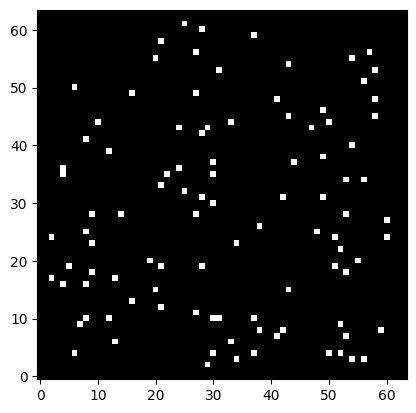

In [68]:
plt.imshow(maskmap.T, cmap = "gray", origin = "lower")

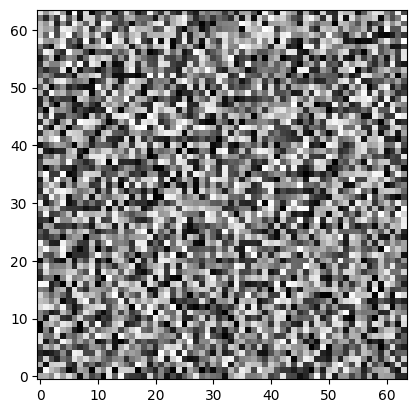

In [69]:
outputs = np.random.randint(0, 256, (64, 64), dtype=np.uint8)
plt.imshow(outputs.T, cmap = "gray", origin = "lower")

In [70]:
result = outputs * maskmap

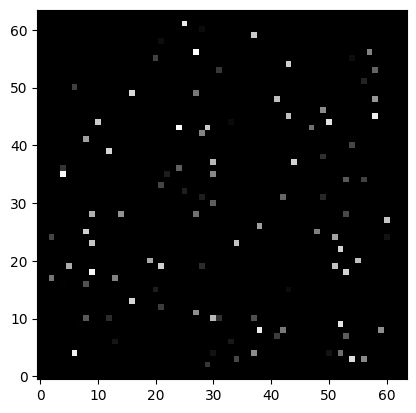

In [71]:
plt.imshow(result.T, cmap = "gray", origin = "lower")

In [72]:
targets = np.zeros((64, 64), dtype=np.int8)

for i in range(len(coordinate)):
        row, col, value = coordinate[i][0], coordinate[i][1], coordinate[i][2]
        maskmap[row, col] = 1
        targets[row, col] = value

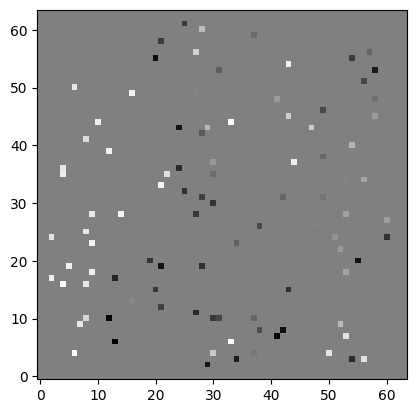

In [73]:
plt.imshow(targets.T, cmap = "gray", origin = "lower")

In [76]:
loss = outputs - targets

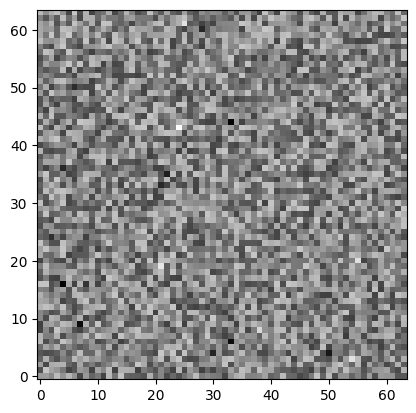

In [77]:
plt.imshow(loss.T, cmap = "gray", origin = "lower")

In [ ]:
def add_maskmap(outputs, coordinate):
    maskmap = np.zeros((64, 64), dtype=np.int8)
    targets = np.zeros((64, 64), dtype=np.int8)

    for i in range(len(coordinate)):
        row, col, value = coordinate[i][0], coordinate[i][1], coordinate[i][2]
        maskmap[row, col] = 1
        targets[row, col] = value
        
    outputs = outputs * maskmap

    return outputs, targets

Text(0.5, 1.0, 'Replaced Receptive')

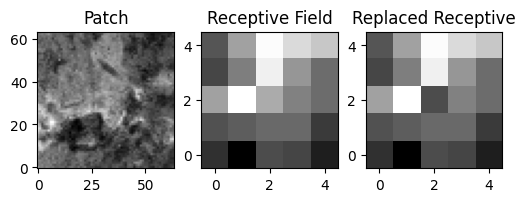

In [38]:
plt.figure(figsize = (6, 2))

plt.subplot(1, 3, 1)
plt.imshow(patch.T, cmap = "gray", origin = "lower")
plt.title('Patch')

plt.subplot(1, 3, 2)
plt.imshow(receptive_field.T, cmap = "gray", origin = "lower")
plt.title('Receptive Field')

plt.subplot(1, 3, 3)
plt.imshow(replaced_receptive_field.T, cmap = "gray", origin = "lower")
plt.title('Replaced Receptive')

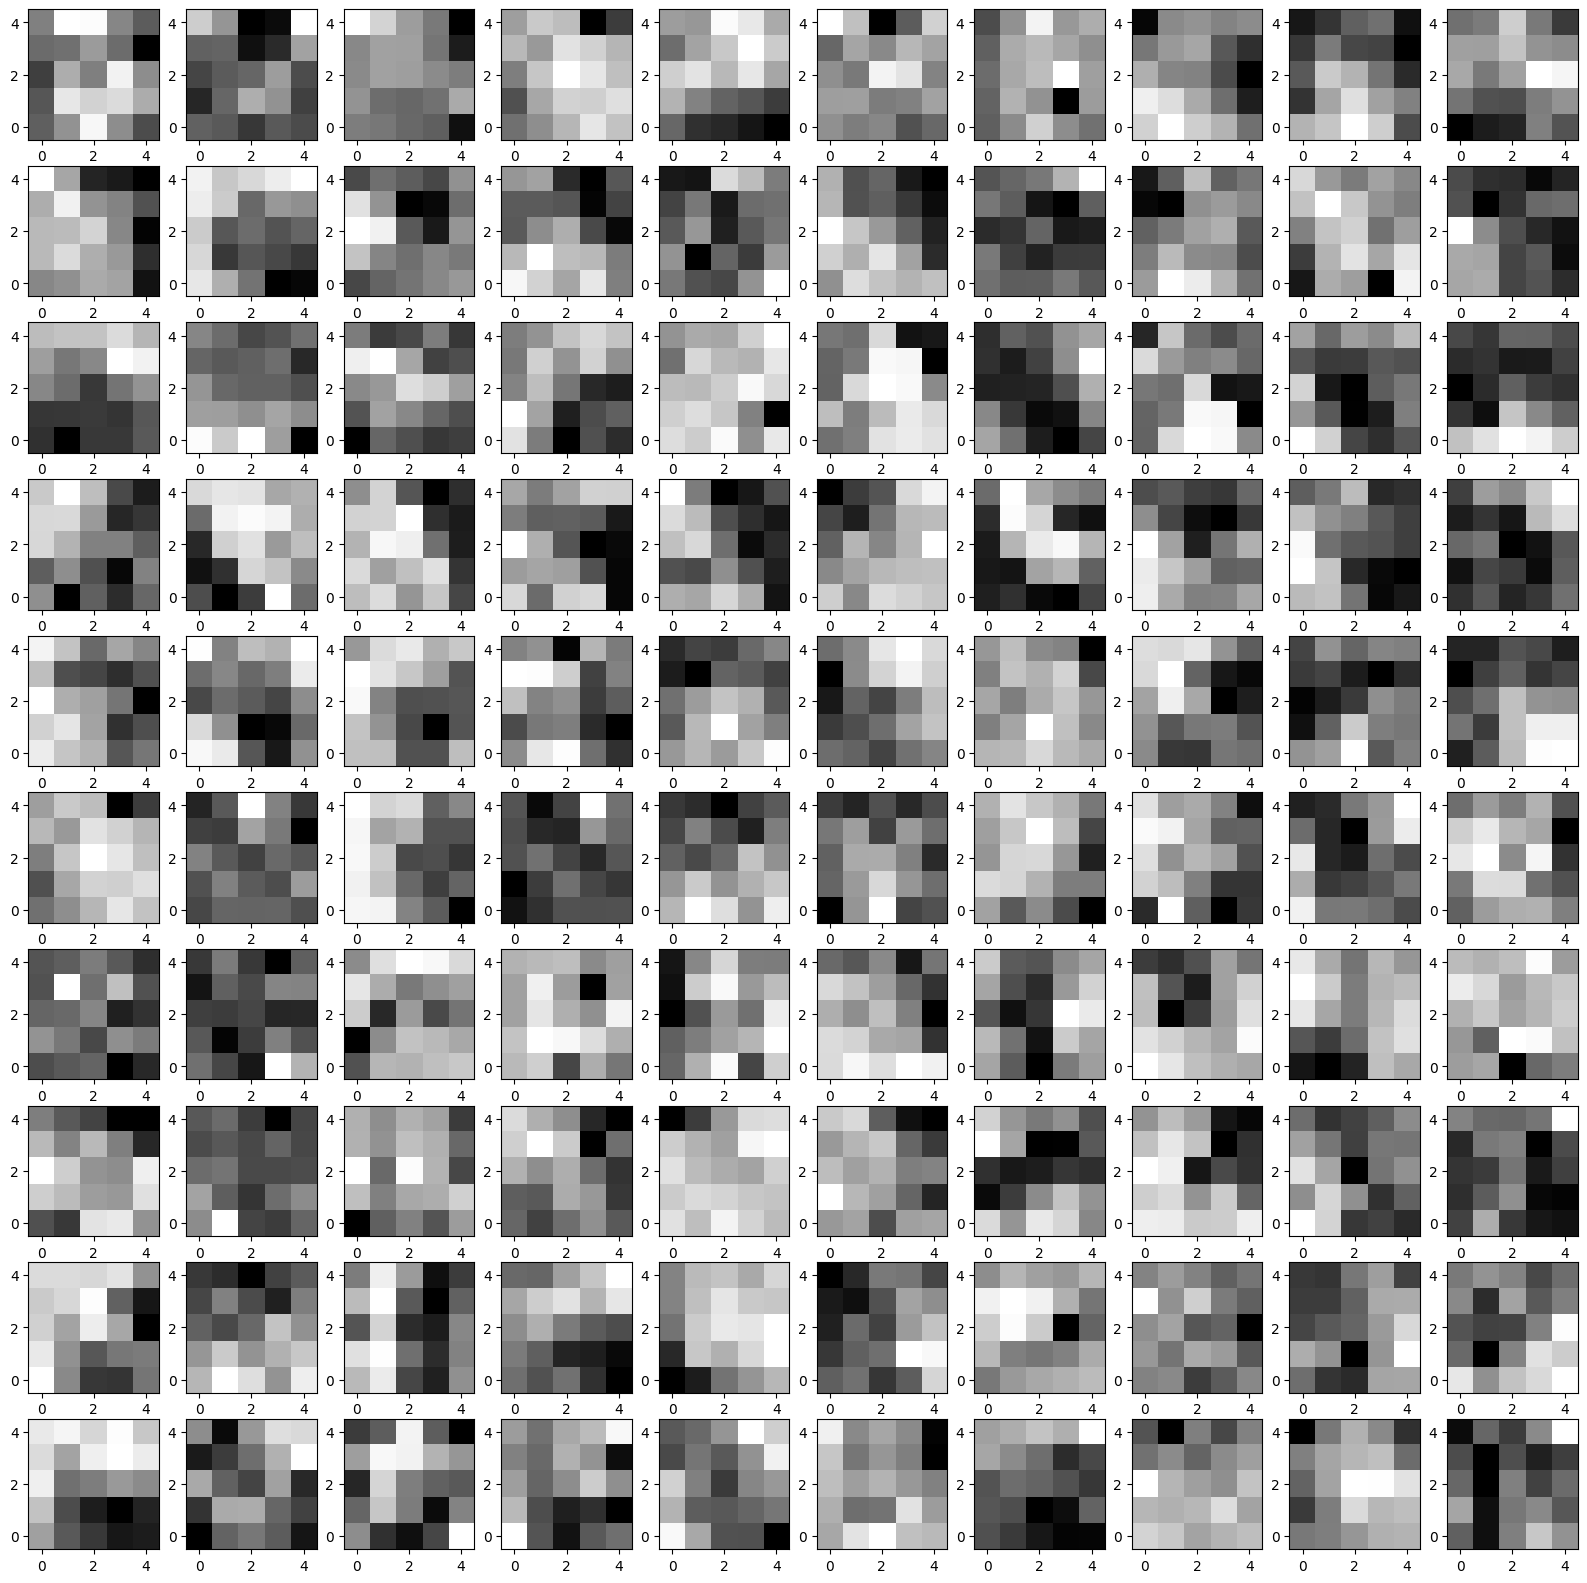

In [40]:
recep_list = []
for i in range(100):
    recep_list.append(generate_receptive_field(patch_list[0], 5))

plt.figure(figsize = (20, 20))
for i in range(len(recep_list)):
    plt.subplot(10, 10, i + 1)
    plt.imshow(recep_list[i].T, cmap = "gray", origin = "lower")

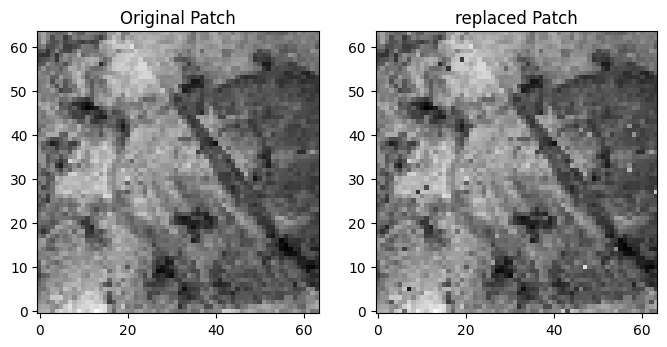

In [36]:
patch = patch_list[0]
num_pixels = 100

patched_image, mask_indices = apply_mask(patch, num_pixels)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(patch.T, cmap='gray', origin="lower")
plt.title('Original Patch')

plt.subplot(1, 2, 2)
plt.imshow(patched_image.T, cmap='gray', origin = "lower")
plt.title('replaced Patch')

plt.show()

## 시각화

In [2]:
def min_max_normalize(image):
    min_val = image.min()
    max_val = image.max()
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def denormalize(image, min_val, max_val):
    denormalized_image = image * (max_val - min_val) + min_val
    return denormalized_image

#예측을 위한 함수 정의
def denoise_image(model, image_path):
    # 이미지 불러오기
    nifti = nib.load(image_path)
    image = nifti.get_fdata()
    image = image[:, :, 16]

    min_val = image.min()
    max_val = image.max()
    
    # normalize
    image = min_max_normalize(image)

    image_tensor = transforms.ToTensor()(image).unsqueeze(0).type(torch.float32)

    # 모델에 이미지 전달
    with torch.no_grad():
        model.eval()
        denoised_image = model(image_tensor)

    # denormalize
    denormalize(denoised_image, min_val, max_val)
    
    return denoised_image.squeeze().cpu().numpy()

In [25]:
image_path = "C:/Users/user/Desktop/인턴/train/I001.nii.gz"

# 모델 정의 및 저장된 파라미터 불러오기
model = UNet_model(1, 1, False)  
model.load_state_dict(torch.load("C:/Users/user/dicom/model/model_2/weights_log/model_0173.pth")) 

# denoise_image 함수를 사용하여 denoised 이미지 생성
denoised_image = denoise_image(model, image_path)

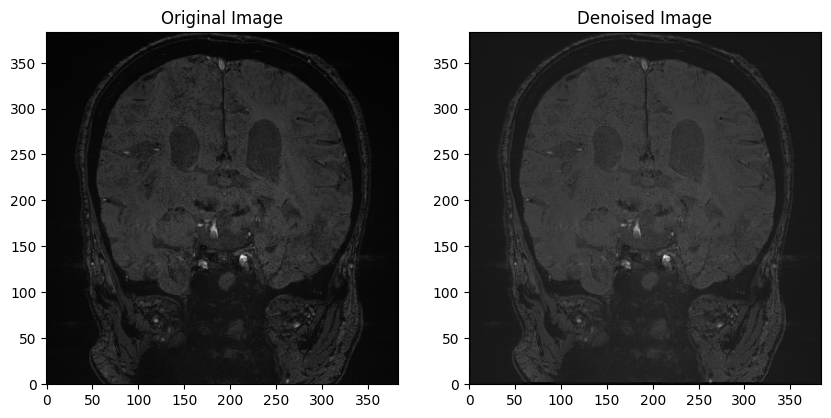

0.0 3048.0 334.3731689453125 227.66527783717257
-0.07473015 1.0836713 0.11610308 0.07439399


In [27]:
# 이미지 불러오기
nifti = nib.load(image_path)
image = nifti.get_fdata()
image = image[:, :, 16]
image.shape

# 시각화
original_image = image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image.T, cmap='gray', origin = 'lower')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image.T, cmap='gray', origin = "lower")
plt.title('Denoised Image')

plt.show()
print(np.min(original_image), np.max(original_image), np.mean(original_image), np.std(original_image))
print(np.min(denoised_image), np.max(denoised_image), np.mean(denoised_image), np.std(denoised_image))

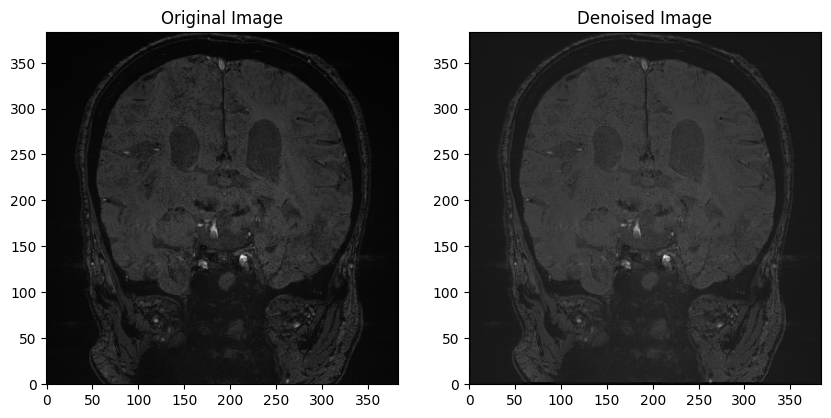

0.0 3048.0 334.3731689453125 227.66527783717257
-0.07473015 1.0836713 0.11610308 0.07439399


In [28]:
# 시각화
original_image = image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image.T, cmap='gray', origin = 'lower')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image.T, cmap='gray', origin = "lower")
plt.title('Denoised Image')

plt.show()
print(np.min(original_image), np.max(original_image), np.mean(original_image), np.std(original_image))
print(np.min(denoised_image), np.max(denoised_image), np.mean(denoised_image), np.std(denoised_image))